In [4]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

current_palette = sns.color_palette(("#000000",))
cmap = ListedColormap(sns.color_palette(current_palette).as_hex())

sns.set(rc={'figure.figsize':(6,4)}, font_scale=1.0, style='whitegrid', font='CMU Sans Serif')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

def save_fig(ax, folder, suffix, format=".pdf"):
    fig = ax.get_figure()
    fig.tight_layout()

    fig.savefig(folder + suffix + format)
    fig.clear()

In [5]:
df_paper = pd.DataFrame()

for experiment in ["server", "satellite"]:
    for run in ["1", "2", "3"]:

        required_length = 10 * 60 * 1e9
        #cutoff = (actual_length - required_length) / 2

        expected_path = os.path.join("..", "results", experiment, run, "tracker.csv" )

        expected_df = pd.read_csv(expected_path)

        min_t = 0.0
        if experiment == "server":
            min_t = expected_df[expected_df["path1dist"] > 23.0]["t"].min()
        elif experiment == "satellite":
            min_t = expected_df[expected_df["path2dist"] > 2.0]["t"].min()


        start = min_t# + 100 * 1e9
        end = start + required_length

        expected_df["t"] = expected_df["t"] - start

        # cut off some stuff
        expected_df = expected_df[(0 <= expected_df["t"]) & (expected_df["t"] <= required_length)]



        for client in ["1", "2", "3"]:

            df = pd.read_csv(os.path.join("..", "results", experiment, run, client + ".csv" ))
            other_clients = df["id"].unique()

            actual_length = df["send_time"].max() - df["send_time"].min()
            print(actual_length/1e9)

            #df["send_time"] = df["send_time"] - min_t
            #df["recv_time"] = df["recv_time"] - min_t

            # cut off some stuff

            df = df[(start <= df["send_time"]) & (df["send_time"] <= end)]
            #df = df[df["latency"] < 500]

            actual_length = df["send_time"].max() - df["send_time"].min()
            print(actual_length/1e9)

            min_t_now = df["send_time"].min()
            df["send_time"] = df["send_time"] - min_t_now

            df["recv_time"] = df["recv_time"] - min_t_now

            actual_length = df["send_time"].max() - df["send_time"].min()
            print(actual_length/1e9)

            for other in other_clients:
                o = str(other)

                df_run = df[(df["id"] == other)][["latency"]].copy()
                # transform index into column and add other columns needed for the figure
                df_run.reset_index(inplace=True, drop=True)
                df_run.insert(0, "Experiment", experiment)
                df_run.insert(1, "Run", run)
                #df_run.insert(2, "Path", min(client, o) + "-" + max(client, o))
                df_run.insert(2, "Path", o + "-" + client)

                # set column names
                df_run.columns = ["Experiment", "Run", "Path", "Latency"]
                # calculate distribution
                df_paper = df_paper.append(df_run)

df_paper.sort_values(by=["Experiment"], inplace=True)
df_paper.reset_index(inplace=True, drop=True) # optionally reset index

df_paper

647.660389888
597.411473408
597.411473408
648.358293504
597.999697664
597.999697664
648.358293504
597.999697664
597.999697664
647.854826752
597.69797632
597.69797632
645.08589056
594.79465216
594.79465216
647.972277248
597.69797632
597.69797632
651.542534656
599.996351232
599.996351232
646.372124416
599.993561088
599.993561088
651.542534656
599.996351232
599.996351232
657.630340864
599.991361536
599.991361536
657.76747904
599.984559616
599.984559616
651.335744768
599.990734848
599.990734848
656.747031552
599.994708224
599.994708224
654.019089152
599.983681536
599.983681536
656.659459328
599.994708224
599.994708224
653.648069888
599.99475968
599.99475968
658.515869184
599.977052416
599.977052416
658.196393472
599.998304
599.998304


,Experiment,Run,Path,Latency
0,satellite,3,2-3,12.35
1,satellite,1,2-3,9.33
2,satellite,1,2-3,8.75
3,satellite,1,2-3,8.25
4,satellite,1,2-3,8.08
...,...,...,...,...
6978375,server,2,2-3,42.52
6978376,server,2,2-3,42.46
6978377,server,2,2-3,42.20
6978378,server,2,2-3,43.43


In [6]:
df_cdf_paper = pd.DataFrame()

for experiment in ["server", "satellite"]:
    for run in ["1", "2", "3"]:
        for client in ["1", "2", "3"]:
            for other in ["1", "2", "3"]:
                if client == other:
                    continue

                df_run = df_paper[(df_paper["Path"] == client + "-" + other) & (df_paper["Run"] == run) & (df_paper["Experiment"] == experiment)]
                # create dataframe new dataframe with counts per latency per run per threshold
                df_tmp = pd.DataFrame(dict(Counter(df_run["Latency"])), index=[0]).T
                # transform index into column and add other columns needed for the figure
                df_tmp.reset_index(inplace=True)
                df_tmp.insert(0, "Experiment", experiment)
                df_tmp.insert(1, "Run", run)
                #df_tmp.insert(2, "Path", min(client, o) + "-" + max(client, o))
                df_tmp.insert(2, "Path", client + "-" + other)
                # set column names
                df_tmp.columns = ["Experiment", "Run", "Path", "Latency", "Count"]
                # calculate distribution
                df_tmp.sort_values(by="Latency", ascending=True, inplace=True)
                df_tmp["cumsum"] = df_tmp["Count"].cumsum()
                sum = df_tmp["Count"].sum()
                df_tmp["Cumulative Distribution"] = df_tmp["cumsum"] / sum
                # add to result df
                df_cdf_paper = df_cdf_paper.append(df_tmp)

df_cdf_paper.sort_values(by=["Experiment"], inplace=True)
df_cdf_paper.reset_index(inplace=True, drop=True) # optionally reset index

df_cdf_paper

,Experiment,Run,Path,Latency,Count,cumsum,Cumulative Distribution
0,satellite,1,2-3,14.45,89,149169,0.765668
1,satellite,2,2-1,18.61,37,174364,0.905157
2,satellite,2,2-1,18.62,29,174393,0.905307
3,satellite,2,2-1,18.63,38,174431,0.905505
4,satellite,2,2-1,18.64,28,174459,0.905650
...,...,...,...,...,...,...,...
158034,server,3,1-2,46.94,266,126076,0.647005
158035,server,3,1-2,46.93,229,125810,0.645640
158036,server,3,1-2,46.92,262,125581,0.644465
158037,server,3,1-2,47.20,202,132851,0.681773


In [7]:
df_cdf_paper[df_cdf_paper["Path"]=="2-3"]

,Experiment,Run,Path,Latency,Count,cumsum,Cumulative Distribution
0,satellite,1,2-3,14.45,89,149169,0.765668
10186,satellite,2,2-3,172.71,1,192609,0.999865
10187,satellite,2,2-3,172.83,1,192610,0.999870
10188,satellite,2,2-3,172.99,1,192611,0.999875
10189,satellite,2,2-3,173.18,1,192612,0.999881
...,...,...,...,...,...,...,...
150269,server,2,2-3,67.95,2,193507,0.996288
150270,server,2,2-3,67.94,2,193505,0.996278
150271,server,2,2-3,67.93,1,193503,0.996267
150272,server,2,2-3,68.56,1,193535,0.996432


Text(0.5, 0, 'Latency [ms]')

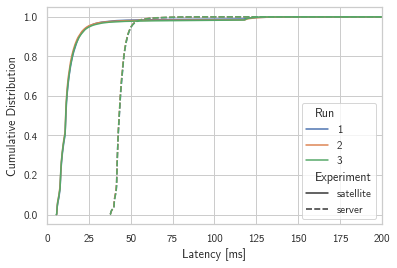

In [8]:
ax_cdf_paper = sns.lineplot(x="Latency", y="Cumulative Distribution", data=df_cdf_paper[df_cdf_paper["Path"]=="2-3"], style="Experiment", hue="Run", ci=None)

#norm = plt.Normalize(0, 80)
#ticks = ["Server", "Satellite"]
#colorbar = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
ax_cdf_paper.set_xlim(0, 200)
#ax_cdf_paper.get_legend().remove()
#ax_cdf_paper.figure.colorbar(colorbar, ticks=ticks).set_label("Experiment")
ax_cdf_paper.set_xlabel("Latency [ms]")

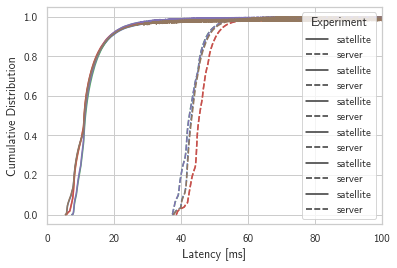

In [9]:
for path in df_cdf_paper["Path"].unique():
    ax_cdf_paper = sns.lineplot(x="Latency", y="Cumulative Distribution", data=df_cdf_paper[(df_cdf_paper["Path"]==path)], style="Experiment", ci=None)

    ax_cdf_paper.set_xlim(0, 100)
    ax_cdf_paper.set_xlabel("Latency [ms]")
    #save_fig(ax_cdf_paper, "results-cdf-" + path)

In [10]:
# sort a bit
df_cdf_paper["Bridge Server"] = df_cdf_paper.apply((lambda x: "Satellite" if x["Experiment"] == "satellite" else "Cloud"), axis=1)
df_cdf_paper

,Experiment,Run,Path,Latency,Count,cumsum,Cumulative Distribution,Bridge Server
0,satellite,1,2-3,14.45,89,149169,0.765668,Satellite
1,satellite,2,2-1,18.61,37,174364,0.905157,Satellite
2,satellite,2,2-1,18.62,29,174393,0.905307,Satellite
3,satellite,2,2-1,18.63,38,174431,0.905505,Satellite
4,satellite,2,2-1,18.64,28,174459,0.905650,Satellite
...,...,...,...,...,...,...,...,...
158034,server,3,1-2,46.94,266,126076,0.647005,Cloud
158035,server,3,1-2,46.93,229,125810,0.645640,Cloud
158036,server,3,1-2,46.92,262,125581,0.644465,Cloud
158037,server,3,1-2,47.20,202,132851,0.681773,Cloud


Text(46.5, 0.5, '46ms')

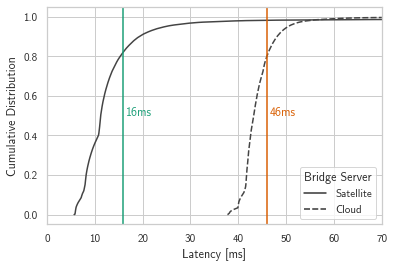

In [11]:
ax_cdf_paper = sns.lineplot(x="Latency", y="Cumulative Distribution", data=df_cdf_paper[(df_cdf_paper["Path"]=="2-3") & (df_cdf_paper["Run"]=="1") ], style="Bridge Server", ci=None, color="#444444")

#norm = plt.Normalize(0, 80)
#ticks = ["Server", "Satellite"]
#colorbar = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
ax_cdf_paper.set_xlim(0, 70)
#ax_cdf_paper.get_legend().remove()
#ax_cdf_paper.figure.colorbar(colorbar, ticks=ticks).set_label("Experiment")
ax_cdf_paper.set_xlabel("Latency [ms]")
ax_cdf_paper.axvline(16, 0 ,1, color="#1b9e77")
ax_cdf_paper.axvline(46, 0 ,1, color="#d95f02")
ax_cdf_paper.text(16.5, 0.5,"16ms", color="#1b9e77")
ax_cdf_paper.text(46.5, 0.5,"46ms", color="#d95f02")

In [12]:
df_cdf_paper["Path"].unique()

array(['2-3', '2-1', '1-3', '1-2', '3-1', '3-2'], dtype=object)

In [14]:
sns.set(rc={'figure.figsize':(6,4)}, font_scale=1.5, style='whitegrid', font='CMU Sans Serif')

for path in ["1-2", "1-3", "2-3"]:
    ax_cdf_paper.clear()
    ax_cdf_paper = sns.lineplot(x="Latency", y="Cumulative Distribution", data=df_cdf_paper[(df_cdf_paper["Path"]==path) & (df_cdf_paper["Run"]=="1")], style="Bridge Server", ci=None, color="#444444")

    ax_cdf_paper.set_xlim(0, 75)
    ax_cdf_paper.set_xlabel("Latency [ms]")
    ax_cdf_paper.axvline(16, 0, 1, color="#1b9e77")
    ax_cdf_paper.axvline(46, 0, 1, color="#d95f02")
    ax_cdf_paper.text(16.75, 0.5, "16ms", color="#1b9e77")
    ax_cdf_paper.text(46.75, 0.5, "46ms", color="#d95f02")
    save_fig(ax_cdf_paper, "./paper/", "results-cdf-" + path)

sns.set(rc={'figure.figsize':(6,4)}, font_scale=1.0, style='whitegrid', font='CMU Sans Serif')

webf NOT subset; don't know how to subset; dropped
webf NOT subset; don't know how to subset; dropped
webf NOT subset; don't know how to subset; dropped


<Figure size 432x288 with 0 Axes>

In [15]:
for run in ["1", "2", "3"]:
    for experiment in ["satellite", "server"]:
        for path in df_cdf_paper["Path"].unique():
            ax_cdf_paper.clear()
            ax_cdf_paper = sns.lineplot(x="Latency", y="Cumulative Distribution", data=df_cdf_paper[(df_cdf_paper["Path"]==path) & (df_cdf_paper["Run"]==run) & (df_cdf_paper["Experiment"]==experiment)], color="#444444", ci=None)

            ax_cdf_paper.set_xlim(0, 70)
            ax_cdf_paper.set_xlabel("Latency [ms]")
            if experiment == "satellite":
                ax_cdf_paper.axvline(16, 0 ,1, color="#1b9e77")
                ax_cdf_paper.text(16.5, 0.5,"16ms", color="#1b9e77")
            elif experiment == "server":
                ax_cdf_paper.axvline(46, 0 ,1, color="#1b9e77")
                ax_cdf_paper.text(46.5, 0.5,"46ms", color="#1b9e77")

            save_fig(ax_cdf_paper, "./website/cdfs/", "cdf-" + experiment + "-" + path + "-" + run, format=".png")

<Figure size 432x288 with 0 Axes>

Text(46.5, 0.5, '46ms')

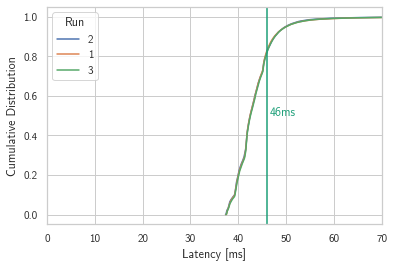

In [16]:

ax_cdf_paper = sns.lineplot(x="Latency", y="Cumulative Distribution", data=df_cdf_paper[(df_cdf_paper["Path"]=="1-3") & (df_cdf_paper["Experiment"]=="server")], hue="Run", ci=None)

ax_cdf_paper.set_xlim(0, 70)
ax_cdf_paper.set_xlabel("Latency [ms]")
ax_cdf_paper.axvline(46, 0 ,1, color="#1b9e77")
ax_cdf_paper.text(46.5, 0.5,"46ms", color="#1b9e77")

In [17]:
df_cdf_paper[(df_cdf_paper["Path"]=="2-3") & (df_cdf_paper["Latency"]==56.49)]

,Experiment,Run,Path,Latency,Count,cumsum,Cumulative Distribution,Bridge Server
120677,server,1,2-3,56.49,3,191077,0.985593,Cloud
130512,server,3,2-3,56.49,9,190710,0.985138,Cloud
146897,server,2,2-3,56.49,3,191672,0.986840,Cloud
